In [ ]:
# This program use u-net to do binary segmentation on ill skin

In [1]:
%load_ext autoreload
%autoreload 1
%aimport config
from __future__ import division

import tensorflow as tf 
from glob import glob
import numpy as np
from PIL import Image
import os
from matplotlib import pyplot as plt

import config as cfg 
from model import u_net

In [15]:
im_paths = sorted(glob(os.path.join(cfg.data_dir, '*.jpg')))
dataset = tf.data.Dataset.from_tensor_slices(im_paths)
dataset = dataset.shuffle(buffer_size = 2000)
dataset = dataset.batch(5)
iterator = dataset.make_one_shot_iterator()
iterator.get_next()
sess = tf.Session()
sess.run(iterator.get_next())

array(['data/ISIC-2017_Training_Data/ISIC_0000137.jpg',
       'data/ISIC-2017_Training_Data/ISIC_0013306.jpg',
       'data/ISIC-2017_Training_Data/ISIC_0012253.jpg',
       'data/ISIC-2017_Training_Data/ISIC_0000317.jpg',
       'data/ISIC-2017_Training_Data/ISIC_0014795.jpg'], dtype=object)

1600


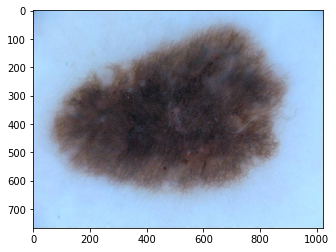

In [4]:
train_writer = tf.python_io.TFRecordWriter(cfg.train_record_path)
val_writer = tf.python_io.TFRecordWriter(cfg.val_record_path)

im_paths = sorted(glob(os.path.join(cfg.data_dir, '*.jpg')))
gt_paths = sorted(glob(os.path.join(cfg.gt_dir, '*.png')))

split_index = int(len(im_paths) * (1 - cfg.val_fraction))
print split_index

# for i in range(len(im_paths)):
for i in range(1):
    im = Image.open(im_paths[i])
    im_data = np.resize(np.array(im) / 255, cfg.im_shape)
    plt.figure()
    plt.imshow(im)
    im_data = im_data.tostring()
    
    test = tf.decode_raw(im_data, tf.float32)
    
    gt = Image.open(gt_paths[i])
    gt_data = np.resize(np.array(gt) / 255, cfg.im_shape[0:-1])
    gt_data = np.array(gt_data, dtype = int)
    gt_data = gt_data.tostring()
    
    images = tf.train.Feature(bytes_list = tf.train.BytesList(value = [im_data]))
    labels = tf.train.Feature(bytes_list = tf.train.BytesList(value = [gt_data]))
    im_shape = tf.train.Feature(int64_list = tf.train.Int64List(value = [cfg.im_shape[0],cfg.im_shape[1],cfg.im_shape[2]]))
    
    features = tf.train.Features(feature = {
        "images" : images,
        "labels" : labels,
        "im_shape" : im_shape
    })
    
    imageFeatures = tf.train.Example(features = features)
    record = imageFeatures.SerializeToString()
    
    if i <= split_index:
        train_writer.write(record)
    else:
        val_writer.write(record)
    
    

In [5]:
def parseExample(example_ptoto):
    feature_dict = {
        "images" : tf.FixedLenFeature(shape = [], dtype = tf.string), 
        "labels" : tf.FixedLenFeature(shape = [], dtype = tf.string),
        "im_shape" : tf.FixedLenFeature(shape = (3), dtype = tf.int64)
    }
    features = tf.parse_single_example(example_ptoto, feature_dict)
    
#     features = tf.train.example(features)
#     features.ParseFromString(featureString)

    im_shape = features['im_shape']
    print im_shape
    
#     images = tf.string_to_number(features['images'], tf.float32)
    images = tf.decode_raw(features['images'], tf.float32)
    images = tf.reshape(images, im_shape)
#     labels = tf.string_to_number(features['labels'], tf.int32)
    
    labels = tf.decode_raw(features['labels'], tf.int32)
    labels = tf.reshape(labels, im_shape[0:-1])
    
    return images, labels
    
dataset = tf.data.TFRecordDataset(cfg.train_record_path)
dataset = dataset.map(parseExample)
# dataset = dataset.batch(1)

iterator = dataset.make_one_shot_iterator()
# images, labels = iterator.get_next()

# sess = tf.Session()
# sess.run(images)
# print images.shape()

# dataset = dataset.shuffle()
# dataset = dataset.batch(cfg.batch_size)
# dataset = dataset.repeat(cfg.epoch)

# prediction, loss = u_net(dataset)

# optimizer = tf.train.GradientDescentOptimizer(cfg.learning_rate)
# train = optimizer.minimize(loss)
# accuracy, _ = tf.metrics.accuracy(y_gt[:,:,:,1], predictions, name = 'my_metric')


Tensor("ParseSingleExample/Squeeze_im_shape:0", shape=(3,), dtype=int64)


In [ ]:
def train():

    im_paths = sorted(glob(os.path.join(cfg.data_dir, '*.png')))
    gt_paths = sorted(glob(os.path.join(cfg.gt_dir, '*.png')))

    split_index = int(len(im_paths) * (1 - cfg.validation_fraction))
    train_set = zip(im_paths[:split_index], gt_paths[:split_index])
    validation_set = zip(im_paths[split_index:], gt_paths[split_index:])

    train_iter = int(len(train_set) / cfg.batch_size)
    validation_iter = int(len(validation_set) / cfg.batch_size)

#     x = tf.placeholder(tf.float32, [None, None, None, 3])
#     y_gt = tf.placeholder(tf.float32, [None, None, None, 2])
    x = tf.placeholder(tf.float32, [None, 2720, 1856, 3])
    y_gt = tf.placeholder(tf.float32, [None, 2720, 1856, 2])
    predictions, loss = u_net(x, y_gt)
    print "----------------load finished-------------------"

    optimizer = tf.train.GradientDescentOptimizer(cfg.learning_rate)
    train = optimizer.minimize(loss)
    accuracy, _ = tf.metrics.accuracy(y_gt[:,:,:,1], predictions, name = 'my_metric')

    # ??????????
    acc_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="my_metric")
    acc_vars_initializer = tf.variables_initializer(var_list=acc_vars)

    init = tf.global_variables_initializer()

    saver = tf.train.Saver()
    sess = tf.Session()
    tf.summary.FileWriter(cfg.visual_dir, sess.graph)

    sess.run(acc_vars_initializer)
    sess.run(init)
    for epoch in range(cfg.epoch):
        np.random.shuffle(train_set)
        np.random.shuffle(validation_set)

        for iter in range(train_iter):
            # inputs = np.array([], dtype = float)
            # labels = np.array([], dtype = int)
            for index in range(cfg.batch_size):
                im = Image.open(train_set[iter * cfg.batch_size + index][0])
                gt = Image.open(train_set[iter * cfg.batch_size + index][1])
                im_data = np.array(im) / 255
                gt_data = np.array(np.array(gt) / 255, dtype = int).reshape(gt.size[1], gt.size[0], 1)

                map = np.ones(gt_data.shape, dtype = int)
                bg_map = map - gt_data
                gt_data = np.concatenate((bg_map, gt_data), axis = 2)

                inputs = im_data.reshape(1, im_data.shape[0], im_data.shape[1], im_data.shape[2])
                labels = gt_data.reshape(1, gt_data.shape[0], gt_data.shape[1], gt_data.shape[2])
                print im_data.shape

                # inputs = np.concatenate((inputs, im_data), axis = 0)
                # labels = np.concatenate((label, gt_data), axis = 0)

            _, loss, acc = sess.run((predictions, loss, accuracy), feed_dict = {x : inputs, y_gt : labels})
    saver.save(sess, cfg.save_path)

if __name__ == '__main__':
    train()

In [1]:
from train import train

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.23) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [6]:
# %load config.py
#files
data_dir = 'data/resize/ISIC-2017_Training_Data'
gt_dir = 'data/resize/ISIC-2017_Training_Part1_GroundTruth'
model_save_path = 'output/'
recordPath = 'data/'

#train
validation_fraction = 0.2
epoch = 50
batch_size = 1
normalize = True
learning_rate = 0.01

#model
depth = 4
filters_first = 64

#tensorboard
visual_dir = '.'

In [ ]:
# %load model.py
from __future__ import division

import tensorflow as tf 

import config as cfg 

def Downsampling_block(inputs, filters):
    x = conv_group(inputs, filters)
    pool_1 = tf.layers.max_pooling2d(x, 2, 2)
    return x, pool_1

def Upsampling_block(input_down, input_up, filters):
    conv_trans = tf.layers.conv2d_transpose(input_up, filters, 2, strides = 2)

    down_feature_shape = tf.shape(input_down)
    up_feature_shape = tf.shape(conv_trans)
    if down_feature_shape[1] % 2 != 0 :
        # height_pad = down_feature_shape[1].value -up_feature_shape[1].value
        # width_pad = down_feature_shape[2].value- up_feature_shape[2].value
        conv_trans = tf.keras.layers.ZeroPadding2D(((0, 1), (0, 0))).apply(conv_trans)
    if down_feature_shape[2] % 2 != 0:
        conv_trans = tf.keras.layers.ZeroPadding2D(((0, 0), (0, 1))).apply(conv_trans)

    x = tf.concat([input_down, conv_trans], axis = 3)
    x = conv_group(x, filters)
    return x

def conv_group(inputs, filters):
    x = tf.layers.conv2d(inputs, filters, 3,  padding = 'same')
    x = tf.nn.relu(x)
    x = tf.layers.conv2d(x, filters, 3,  padding = 'same')
    x = tf.nn.relu(x)
    return x

def u_net(x, y_gt):

    depth = cfg.depth
    filters = cfg.filters_first
    downsample_output = []

    for i in range(depth):
        down_feature_map, x = Downsampling_block(x, filters)
        downsample_output.append(down_feature_map)
        filters = filters * 2

    x = conv_group(x, filters)
    filters = int(filters / 2)

    for i in range(depth):
        x = Upsampling_block(downsample_output[depth - i - 1], x, filters)
        filters = int(filters / 2)

    logits = tf.layers.conv2d(x, 2, 1)

    predictions = tf.argmax(logits, axis = 3)

    loss = tf.losses.softmax_cross_entropy(y_gt, logits)
    return predictions, loss